In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import numpy as np
import pyproj
import xarray as xr
from pathlib import Path

from disp_xr import product, stack as disp_stack, utils, quality_metrics, io
from disp_xr.mintpy_utils.utils import find_reference_point 
from disp_xr.utils import latlon_to_utm, get_extent

In [15]:
# Manually set logging, NOTE change this cell later
import logging
logger = logging.getLogger('disp_xr')

# Configure basic logging
logger.setLevel(logging.INFO)  # Set logging level

# Create handler (console output)
handler = logging.StreamHandler()
handler.setLevel(logging.INFO)  # Set level for this handler

# Add handler to logger
logger.addHandler(handler)

# Prevent duplicate logs if the root logger already has handlers
logger.propagate = False

## Plotting functions

In [120]:
import warnings
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import TwoSlopeNorm
from matplotlib.dates import DateFormatter

In [44]:
def add_colorbar(fig, loc, im, labelsize=4, label='mm/yr', **kwargs):
    warnings.simplefilter("ignore")
    cb_kwargs = dict(orientation='horizontal', extend='neither')
    cbar_ax = fig.add_axes(loc)
    cb = fig.colorbar(im, cax=cbar_ax, **{**cb_kwargs, **kwargs})
    tick_locator = matplotlib.ticker.MaxNLocator(nbins=3)
    cb.locator = tick_locator
    cb.set_ticklabels(cb.get_ticks(), fontsize=labelsize)
    if label: cb.set_label(label, size=labelsize)
    cb.ax.tick_params(axis="both", grid_color='white',
                       which='major', labelsize=labelsize, length=2)
    cb.outline.set_edgecolor('black')
    cb.outline.set_linewidth(0.5)
    cb.update_ticks()
    return cb

def plot_overview(ds1 : xr.DataArray, ds2: xr.DataArray,
                  ref_yx_utm : tuple, labels:list =["1", "2", "diff"],
                  scale=1e2, unit='cm', **kwargs):
    # Subplots positions
    sub_pos = {labels[0]: [0.02, 0.1, 0.31, 0.8],
               labels[1]: [0.35, 0.1, 0.31, 0.8],
               labels[2]: [0.68, 0.1, 0.31, 0.8]}
    
    # Get figure layout
    cm = 1/2.54 # width X height
    fig = plt.figure(figsize=(18*cm, 8*cm), layout="none", dpi=300)
    spec = GridSpec(ncols=2, nrows=1, figure=fig)
    axs = {p:fig.add_subplot(spec[0,0]) for p in sub_pos.keys()} 
    for fig_label in axs: axs[fig_label].set_position(sub_pos[fig_label])

    # Set axes
    label_kwargs =dict(direction="in", length=2, labelsize=8)
    for i, label in enumerate(labels):
        axs[label].tick_params(labelleft=(i == 0), **label_kwargs)
    
    # Default plot kwargs
    plot_kwargs = dict(interpolation='nearest', cmap='jet',
                    clim=[-5, 5], zorder=1, alpha=0.8)
    plot_kwargs = {**plot_kwargs, **kwargs}

    # Plot the data
    im = {}
    extent_ds1 = ds1.attrs['extent']
    extent_ds2 = ds2.attrs['extent']
    im[labels[0]] = axs[labels[0]].imshow(ds1.values * scale,
                                          extent=extent_ds1, **plot_kwargs) 
    im[labels[1]] = axs[labels[1]].imshow(ds2.values * scale,
                                          extent=extent_ds2, **plot_kwargs) 
    
    # Difference plot
    difference =  (ds1 - ds2).values
    difference *= scale
    vmin = np.nanmean(difference) - np.nanstd(difference)/2
    vmax = np.nanmean(difference) + np.nanstd(difference)/2
    divnorm = TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)
    diff_kwargs = dict(cmap='coolwarm', norm=divnorm, clim=[vmin, vmax])
    plot_kwargs = {**plot_kwargs, **diff_kwargs}
    im[labels[2]] = axs[labels[2]].imshow(difference,
                                          extent=extent_ds1, **plot_kwargs) # to cm 

    # Plot the reference point and add title
    for ax, label in zip(axs.values(), labels):
        ax.plot(ref_yx_utm[1], ref_yx_utm[0], 'kx', markersize=3, zorder=2)
        axs[label].set_title(label.upper())
    
    # Add colorbar
    cb = add_colorbar(fig, [0.33-0.1, 0.05, 0.2, 0.01],
                      im[labels[1]], label='', labelsize=6)
    cb.ax.tick_params(direction="in", length=2)
    cb.ax.set_title(f'LOS Cummulative disp. [{unit}]', fontsize=7)

    # add difference colorbar
    cb = add_colorbar(fig, [0.84-0.1, 0.05, 0.2, 0.01],
                      im[labels[2]], label='', labelsize=6)
    cb.ax.tick_params(direction="in", length=2)
    cb.ax.set_title(f'Difference. [{unit}]', fontsize=7)

    return fig, axs

In [ ]:
def _rmse(predictions, targets):
    return np.sqrt(np.nanmean((np.ma.masked_invalid(predictions) - np.ma.masked_invalid(targets)) ** 2))


def plot_scatterplot(ax,
                     data1_ts, data2_ts,
                     label1, label2,
                     scale=1e2, fontsize=6, 
                     unit='cm', **kwargs):
    
    # Convert to pandas
    data1_df = pd.DataFrame(data1_ts).T
    data1_df = data1_df.rename(columns={0:'date1', 1:'disp1'})

    data2_df = pd.DataFrame(data2_ts).T
    data2_df = data2_df.rename(columns={0:'date2', 1:'disp2'})

    # Merge, and keep common dates
    merged_df = pd.merge(data1_df, data2_df,
                         left_on='date1', right_on='date2',
                         how='inner')
    # Get min, and max
    df_min = np.round(np.min(merged_df[['disp1', 'disp2']].min()), 2)
    df_max = np.round(np.max(merged_df[['disp1', 'disp2']].max()), 2)
    ax_range = np.max(np.abs([df_min, df_max]))
    ax_range += ax_range*0.2 # increase by 20%
    ax_lims = [-ax_range*scale, ax_range*scale]

    # text upper corner
    txt_xy = ax_range- ax_range*0.1
    txt_xy *= scale

    yrange = (ax_range*2) * scale
    r = yrange/20

    # Replace pandas nat with nan
    merged_df['disp1'] = merged_df['disp1'].replace({pd.NaT: np.nan})
    merged_df['disp2'] = merged_df['disp2'].replace({pd.NaT: np.nan})

    # Plot
    ax.plot(merged_df.disp1*scale, merged_df.disp2*scale, 'o', **kwargs)
    
    ax.plot(ax_lims, ax_lims, lw=0.5, color='navy')
    ax.set_ylabel(f'{label1} [{unit}]', fontsize=fontsize, labelpad=-0.1)
    ax.set_xlabel(f'{label2} [{unit}]', fontsize=fontsize, labelpad=-0.1)
    ax.set_xlim(ax_lims)
    ax.set_ylim(ax_lims)

    # Get stats
    merged_df = merged_df.dropna()
    rmse = _rmse(merged_df.disp1.values, merged_df.disp2.values)
    mad = stats.median_abs_deviation(merged_df.disp1 - merged_df.disp2)
    r2 = stats.pearsonr(np.float64(merged_df.disp1), np.float64(merged_df.disp2))[0]


    ax.text(-txt_xy, txt_xy, f'R2: {r2:.2f}', weight='bold', fontsize=fontsize-1)
    ax.text(-txt_xy, txt_xy-r, f'RMSE: {rmse*scale:.2f} {unit}', weight='bold', fontsize=fontsize-1)
    ax.text(-txt_xy, txt_xy-r*2, f'MAD: {mad*scale:.2f} {unit}', weight='bold', fontsize=fontsize-1)
    ax.tick_params(direction='in', labelsize=fontsize, length=2)
    return merged_df

def plot_histogram(ax, difference, bins=20, scale=1e2, unit='cm', fontsize=6):
    # histogram of differences
    ax.hist(difference*scale, bins=bins, color='red', alpha=0.5)
    ax.set_xlabel(f'Diff. [{unit}]', fontsize=fontsize, labelpad=-0.2)
    ax.tick_params(direction='in', labelsize=fontsize, length=2, pad=1.5)
    ax.axvline(difference.mean()*scale, color='darkred', linestyle='--', label='Mean')
    return ax

def plot_timeseries(ts1: xr.DataArray, ts2: xr.DataArray,
                    labels=['1','2'], colors=['blue', 'green'],
                    fontsize=8, scale=1e2, unit='cm'):
    # Get figure layout
    sub_pos = {'ts': [0.03, 0.22, 0.73, 0.76],
               'sp': [0.83, 0.25, 0.16, 0.73],
               'hist': [0.83, 0.01, 0.16, 0.15],
               'ts_dif': [0.03, 0.02, 0.73, 0.17]} 

    # Get figure layout
    cm = 1/2.54 # width X height
    fig = plt.figure(figsize=(18*cm, 6*cm), layout="none", dpi=300)
    spec = GridSpec(ncols=2, nrows=1, figure=fig)
    ax = {p:fig.add_subplot(spec[0,0]) for p in sub_pos.keys()} 
    for fig_label in ax: ax[fig_label].set_position(sub_pos[fig_label])

    # Plot timeseries
    ax['ts'].plot(ts1.time, ts1.values * scale, '.',
                  color=colors[0], label=labels[0].upper(), ms=3)
    ax['ts'].plot(ts2.time, ts2.values * scale, '.',
                color=colors[1], label=labels[1].upper(), ms=3) 

    ax['ts'].set_ylabel(f'Disp. [{unit}]', fontsize=fontsize)
    ax['ts'].legend(fontsize=fontsize)
    ax['ts'].tick_params(labelsize=fontsize, labelbottom=False)
    ax['ts'].axhline(0, color='gray', lw=0.3, linestyle='--')

    # Plot scatter plot
    df = plot_scatterplot(ax['sp'],
                          (ts1.time.values, ts1.values), 
                          (ts2.time.values, ts2.values),
                          labels[0].upper(), labels[1].upper(),
                          ms=1, fontsize=fontsize-2,
                          scale=scale, unit=unit)
    
    # histogram of differences
    ax['hist'] = plot_histogram(ax['hist'], df.disp1-df.disp2,
                                scale=scale, unit=unit, fontsize=fontsize-2)

    # Differences
    ax['ts_dif'].bar(df.date1, (df.disp1 - df.disp2)*scale, color='red',
                     width=1e1, label=f'{labels[0].upper()}-{labels[1].upper()}')
    ax['ts_dif'].set_ylabel(f'Diff. [{unit}]', fontsize=fontsize)
    ax['ts_dif'].tick_params(labelsize=fontsize)
    ax['ts_dif'].set_xticks(ax['ts'].get_xticks())
    ax['ts_dif'].set_xlim(ax['ts'].get_xlim())
    ax['ts_dif'].axhline(0, color='r', lw=0.5, linestyle='--')
    ax['ts_dif'].xaxis.set_major_formatter(DateFormatter('%Y/%m'))
    ax['ts_dif'].legend(fontsize=fontsize-2)
    return fig, ax

# Workflow

In [18]:
# Compare OPERA DISP v1.1 with PRODUCTION DISP v1.0
disp_df_prod = product.get_disp_info('/u/operapst/bato/work/CALVAL/disp-s1_official/v1.0/F08622/products')
disp_df_v11 = product.get_disp_info('/u/operapst/bato/work/CALVAL/disp-s1_official/v1.1/F08622/products')

Found OPERA DISP: 209 products
Found OPERA DISP: 209 products


 Starting date: 2016-07-16 22:50:42
 Starting date: 2016-07-16 22:50:42
 Ending date: 2024-08-27 22:51:23
 Ending date: 2024-08-27 22:51:23
 Number of reference dates: 14
 Number of reference dates: 14
 Skip 0 duplicates
 Skip 0 duplicates
Found OPERA DISP: 239 products
Found OPERA DISP: 239 products
 Starting date: 2016-07-16 22:50:42
 Starting date: 2016-07-16 22:50:42
 Ending date: 2024-12-13 22:51:21
 Ending date: 2024-12-13 22:51:21
 Number of reference dates: 16
 Number of reference dates: 16
 Skip 0 duplicates
 Skip 0 duplicates


In [19]:
# Init production stack, stacking all mini-stacks
stack_prod = disp_stack.combine_disp_product(disp_df_prod)

# Init v11 stack, stacking all mini-stacks
stack_v11 = disp_stack.combine_disp_product(disp_df_v11)

Stacking into common stack
Stacking into common stack
 Chunk blocks: {'time': -1, 'x': 512, 'y': 512}
 Chunk blocks: {'time': -1, 'x': 512, 'y': 512}


Total elapsed time for disp_xr.stack.combine_disp_product: 0.31 minutes (18.66 seconds)
Total elapsed time for disp_xr.stack.combine_disp_product: 0.31 minutes (18.66 seconds)
Stacking into common stack
Stacking into common stack
 Chunk blocks: {'time': -1, 'x': 512, 'y': 512}
 Chunk blocks: {'time': -1, 'x': 512, 'y': 512}
Total elapsed time for disp_xr.stack.combine_disp_product: 0.35 minutes (20.78 seconds)
Total elapsed time for disp_xr.stack.combine_disp_product: 0.35 minutes (20.78 seconds)


In [20]:
# Get common dates, start and end date for plotting
common_dates = np.array(stack_prod.time[stack_prod.time.isin(stack_v11.time)])
start_date = np.min(common_dates)
end_date = np.max(common_dates)

In [21]:
# Define the reference point [lat, lon]
reference_yx = (np.float64(40.703502549850235), np.float64(-73.97908275641281))

In [22]:
# Get the epsg code for the reference point
epsg = pyproj.CRS(stack_prod.spatial_ref.attrs['crs_wkt']).to_epsg()

# Get the reference point in UTM
ref_x_utm, ref_y_utm = latlon_to_utm(*reference_yx, epsg)

## Overview

In [23]:
def get_cummulative_displacement(ds: xr.Dataset, date: np.datetime64,
                                 ref_y:float, ref_x:float) -> (xr.DataArray, xr.DataArray):
    """Get the cummulative displacement and re-reference."""
    # Get the displacement at the reference point
    ref_disp = ds.sel(time=date, y=ref_y, x=ref_x, method='nearest').displacement
    
    # Get the cummulative displacement from the reference point
    cumm_disp = (ds.sel(time=date).displacement - ref_disp).compute()
    cumm_disp.attrs['extent'] = get_extent(ds)

    # Get recommended mask
    mask = ds.sel(time=date).recommended_mask.compute()
    return cumm_disp, mask 

In [24]:
%%time
# Get cumulative displacement
prod_cumdisp, prod_mask = get_cummulative_displacement(stack_prod, end_date,
                                                       ref_y_utm, ref_x_utm)

CPU times: user 34.7 s, sys: 4.26 s, total: 38.9 s
Wall time: 43.2 s


In [25]:
%%time
# Get cumulative displacement
v11_cumdisp, v11_mask = get_cummulative_displacement(stack_v11, end_date,
                                                     ref_y_utm, ref_x_utm)

CPU times: user 46.4 s, sys: 5 s, total: 51.4 s
Wall time: 1min 16s


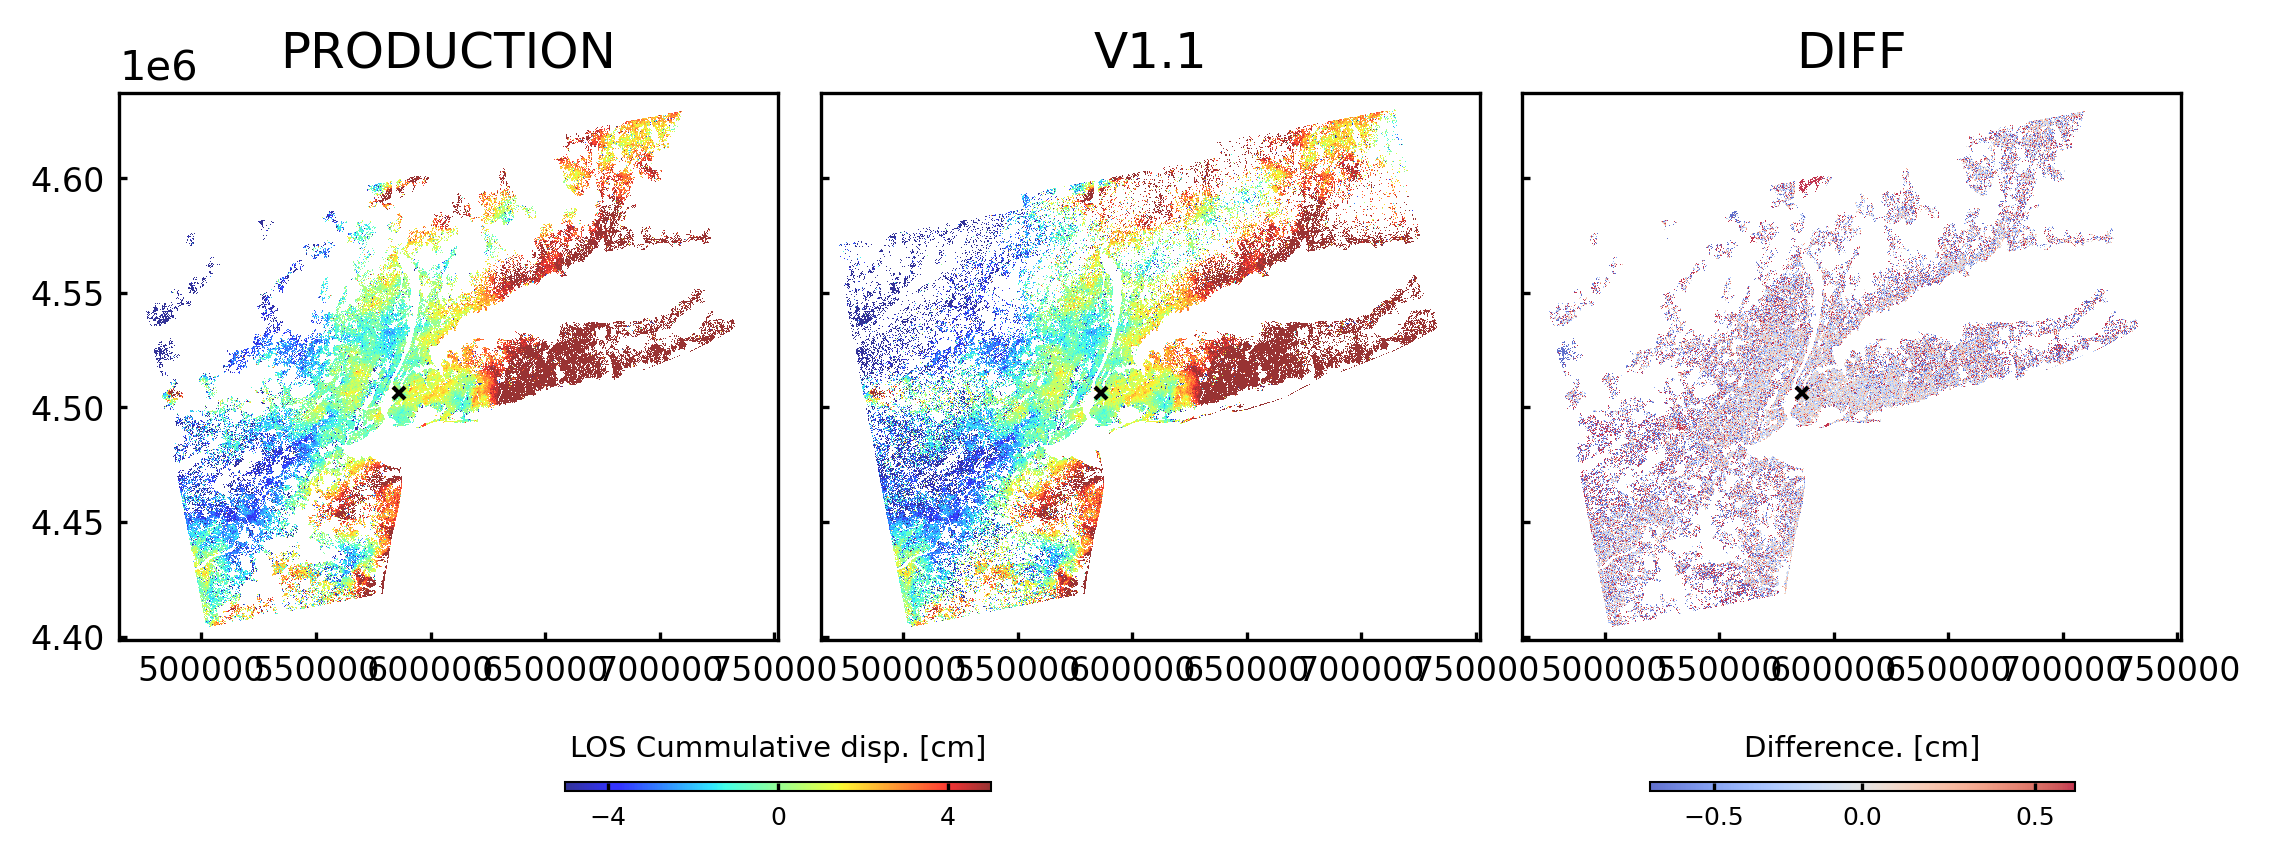

In [45]:
## Plot cummulative displacement on a common last date
## use recommended mask to mask the data
labels = ['PRODUCTION', 'v1.1', 'DIFF']
fig_cumdisp, ax_cumdisp = plot_overview(prod_cumdisp.where(prod_mask==1),
                                        v11_cumdisp.where(v11_mask==1),
                                        (ref_y_utm, ref_x_utm),
                                        labels, scale=1e2, unit='cm')

In [33]:
# Select point for ts comparison
ts_points = [[-73.871854,  40.771890],
             [-73.997618, 40.725698],
             [-73.90194, 40.74775],
             [-73.91977, 40.71759]]

In [37]:
ts_point_utm = [latlon_to_utm(lat, lon, epsg) for lon, lat in ts_points]
ts_point_utm

[(595206.0745226223, 4514047.334405817),
 (584651.0364822878, 4508790.808113095),
 (592700.5552713361, 4511335.386712742),
 (591236.4754025463, 4507968.727221809)]

In [42]:
xmin, xmax = np.array(ts_point_utm)[:,0].min(), np.array(ts_point_utm)[:,0].max()
ymin, ymax = np.array(ts_point_utm)[:,1].min(), np.array(ts_point_utm)[:,1].max()

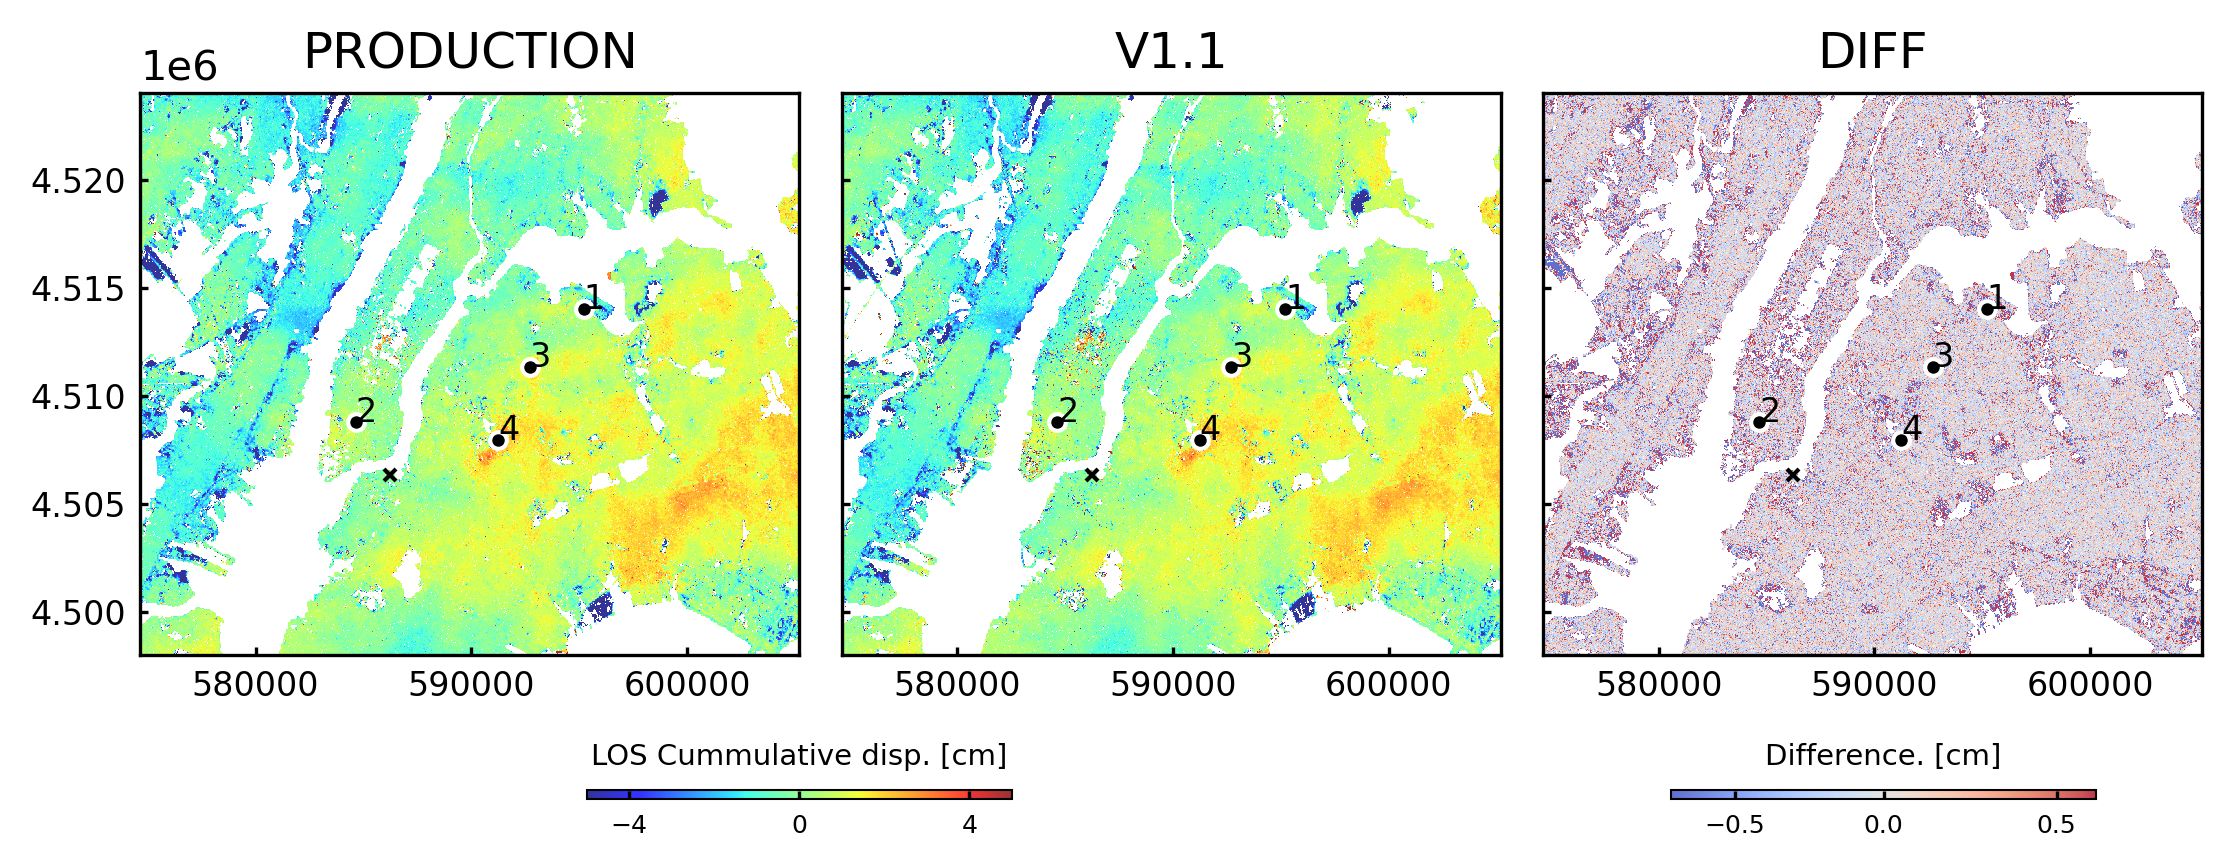

In [46]:
# plot close up of the area around selected points
buffer = 1e4 # 10 km buffer
for ix, pp in enumerate(ts_point_utm):
    for ax in ax_cumdisp.values(): 
        ax.plot(*pp, 'ko', markeredgecolor='white', ms=4)
        ax.annotate(ix+1,(pp[0],pp[1]), fontsize=8)
        ax.set_ylim(ymin-buffer, ymax+buffer)
        ax.set_xlim(xmin-buffer, xmax+buffer)
display(fig_cumdisp)

## Timeseries

In [82]:
def get_timeseries(ds: xr.Dataset, 
                    y:float, x:float, 
                    ref_yx:tuple,
                    radius:float=10) -> xr.DataArray:
    
    # Get the displacement timeseries at the point
    selection = dict(y=slice(y + radius, y - radius),
                     x=slice(x - radius, x + radius))

    ts = ds.sel(selection).displacement
    mask = ds.sel(selection).recommended_mask 

    # Get the average of values within the radius
    avg_ts = ts.where(mask==1).mean(dim=['x','y'])

    # Get the reference data
    reference_ts = ds.sel(y=ref_yx[0], x=ref_yx[1], method='nearest').displacement

    # Rereference the timeseries
    avg_ts -= reference_ts

    return avg_ts.compute()

CPU times: user 1min 47s, sys: 22.3 s, total: 2min 10s
Wall time: 2min 42s


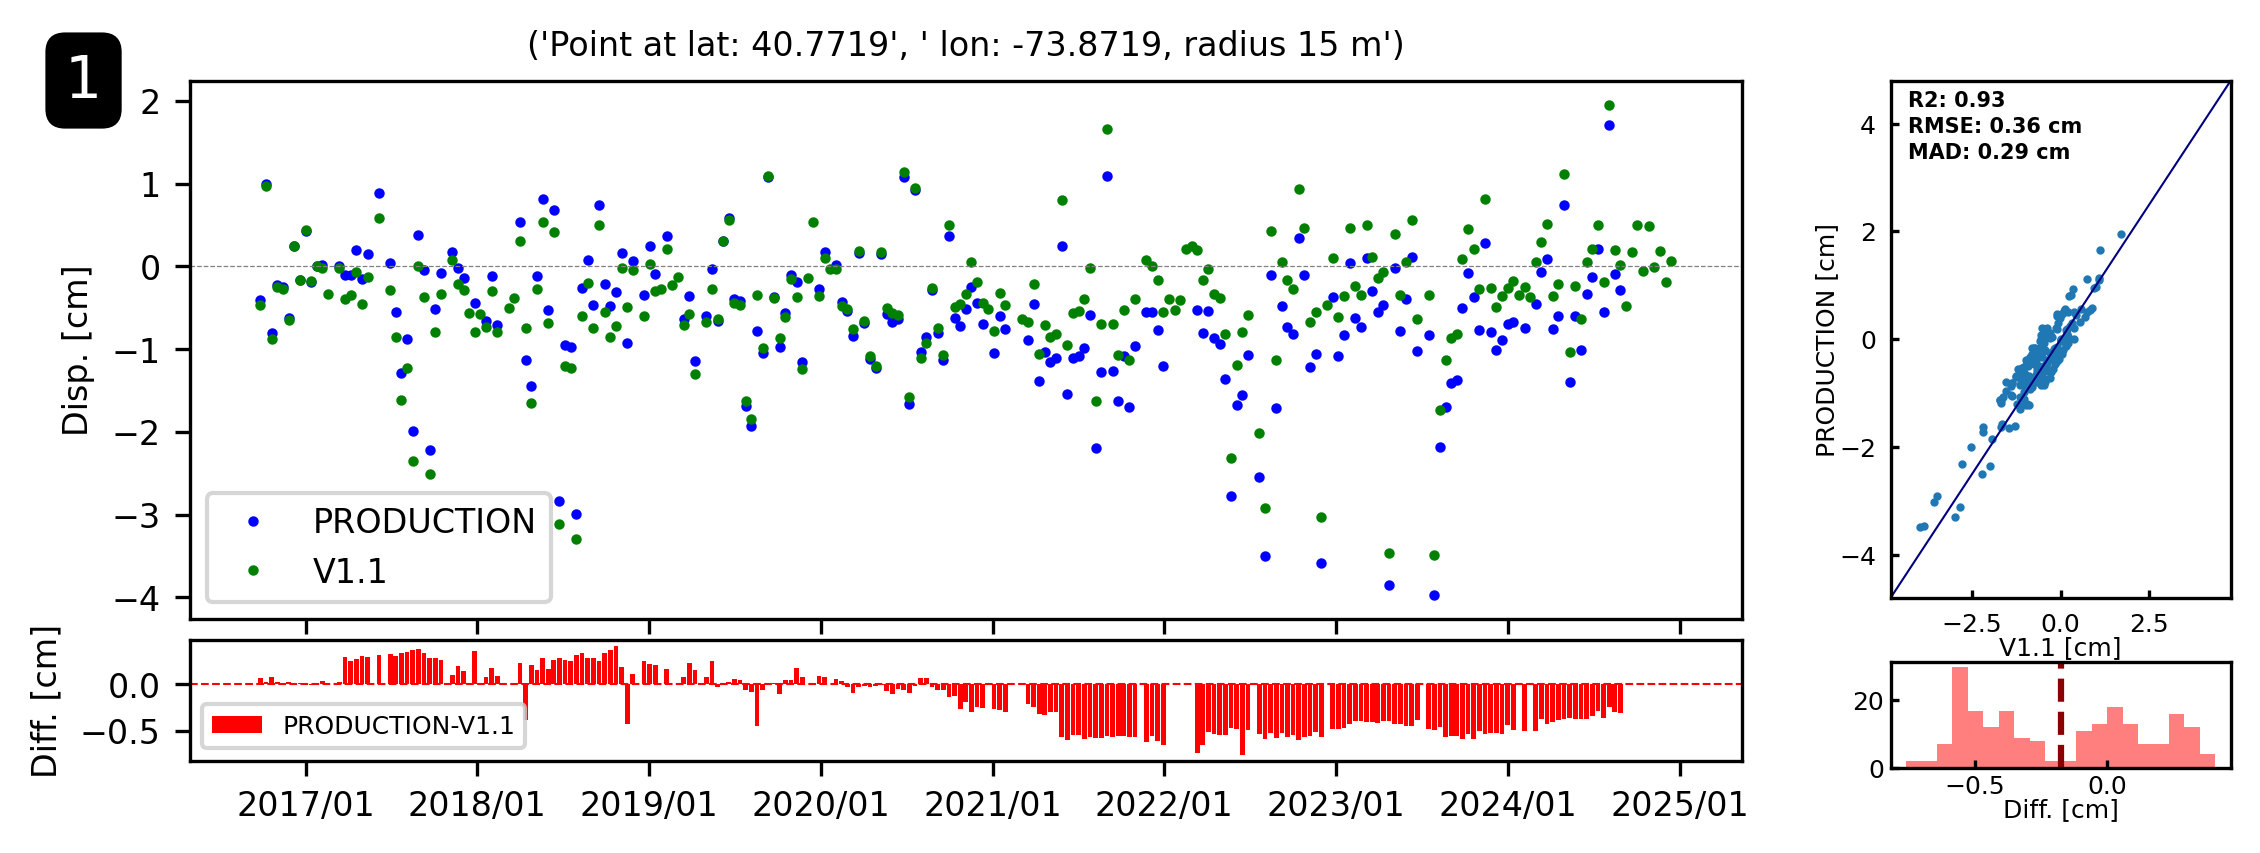

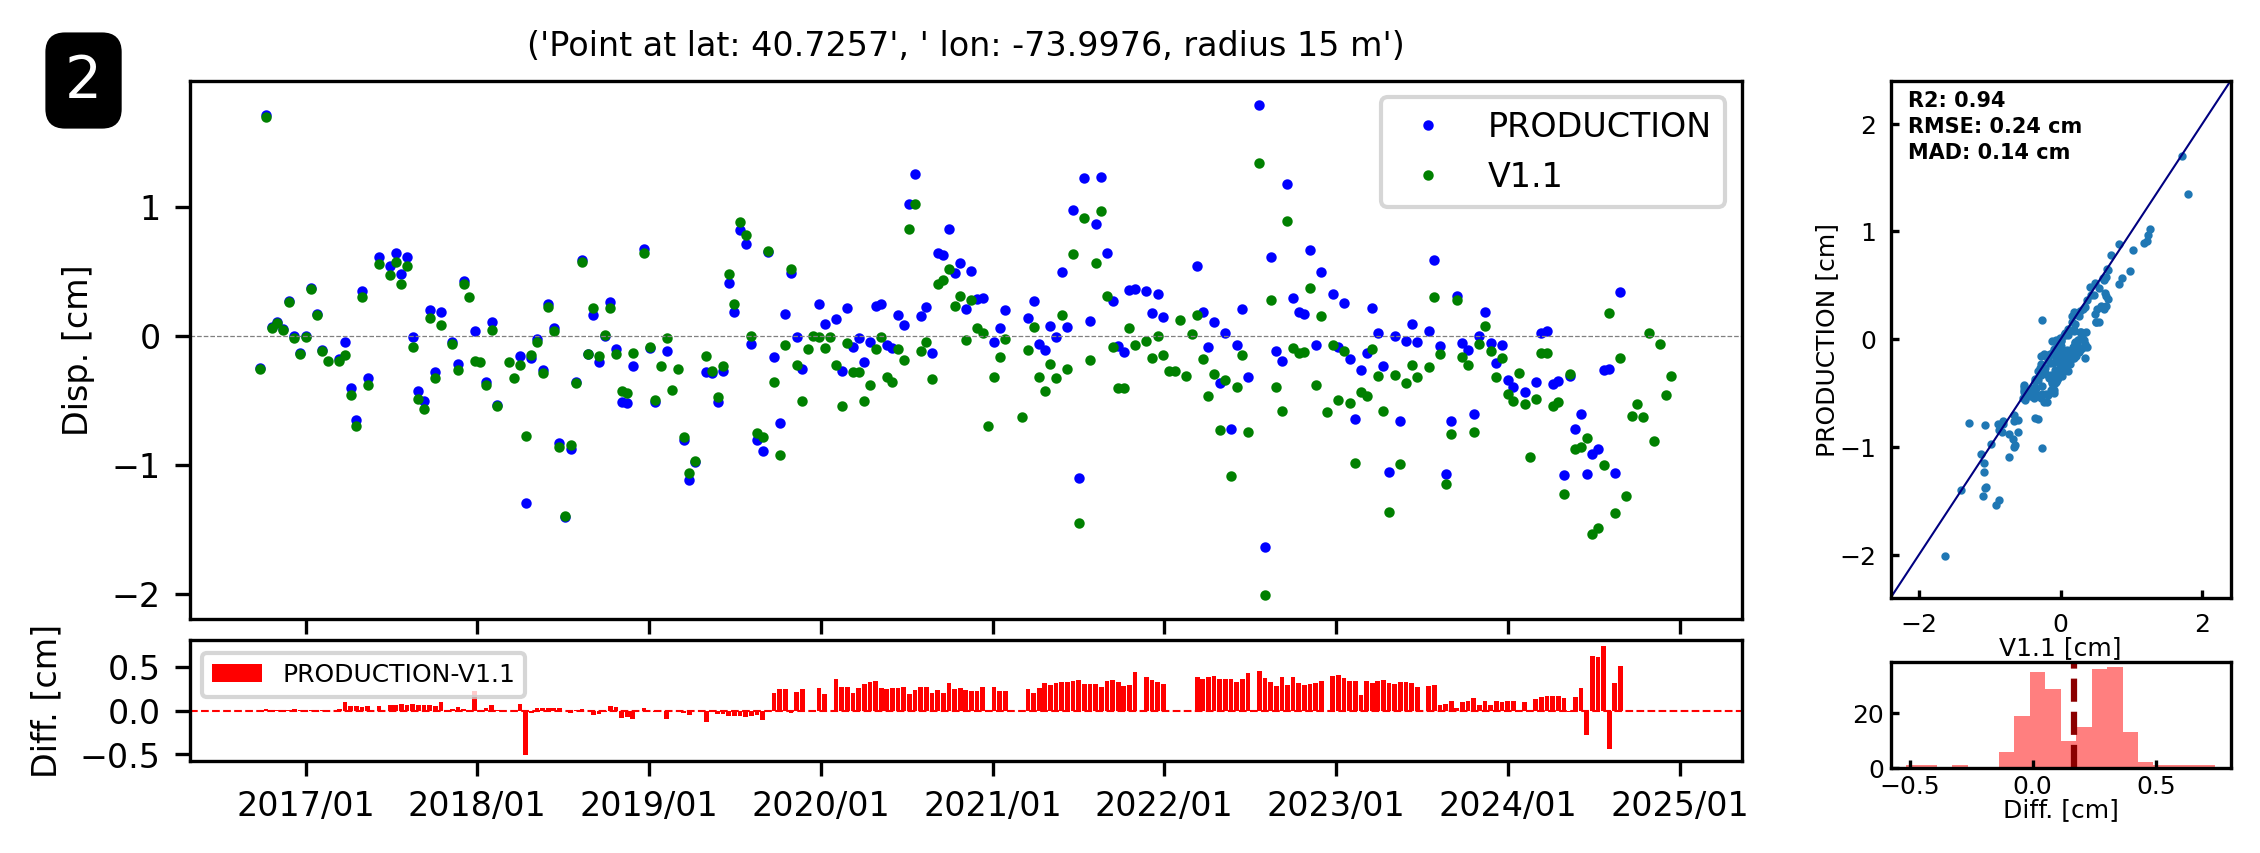

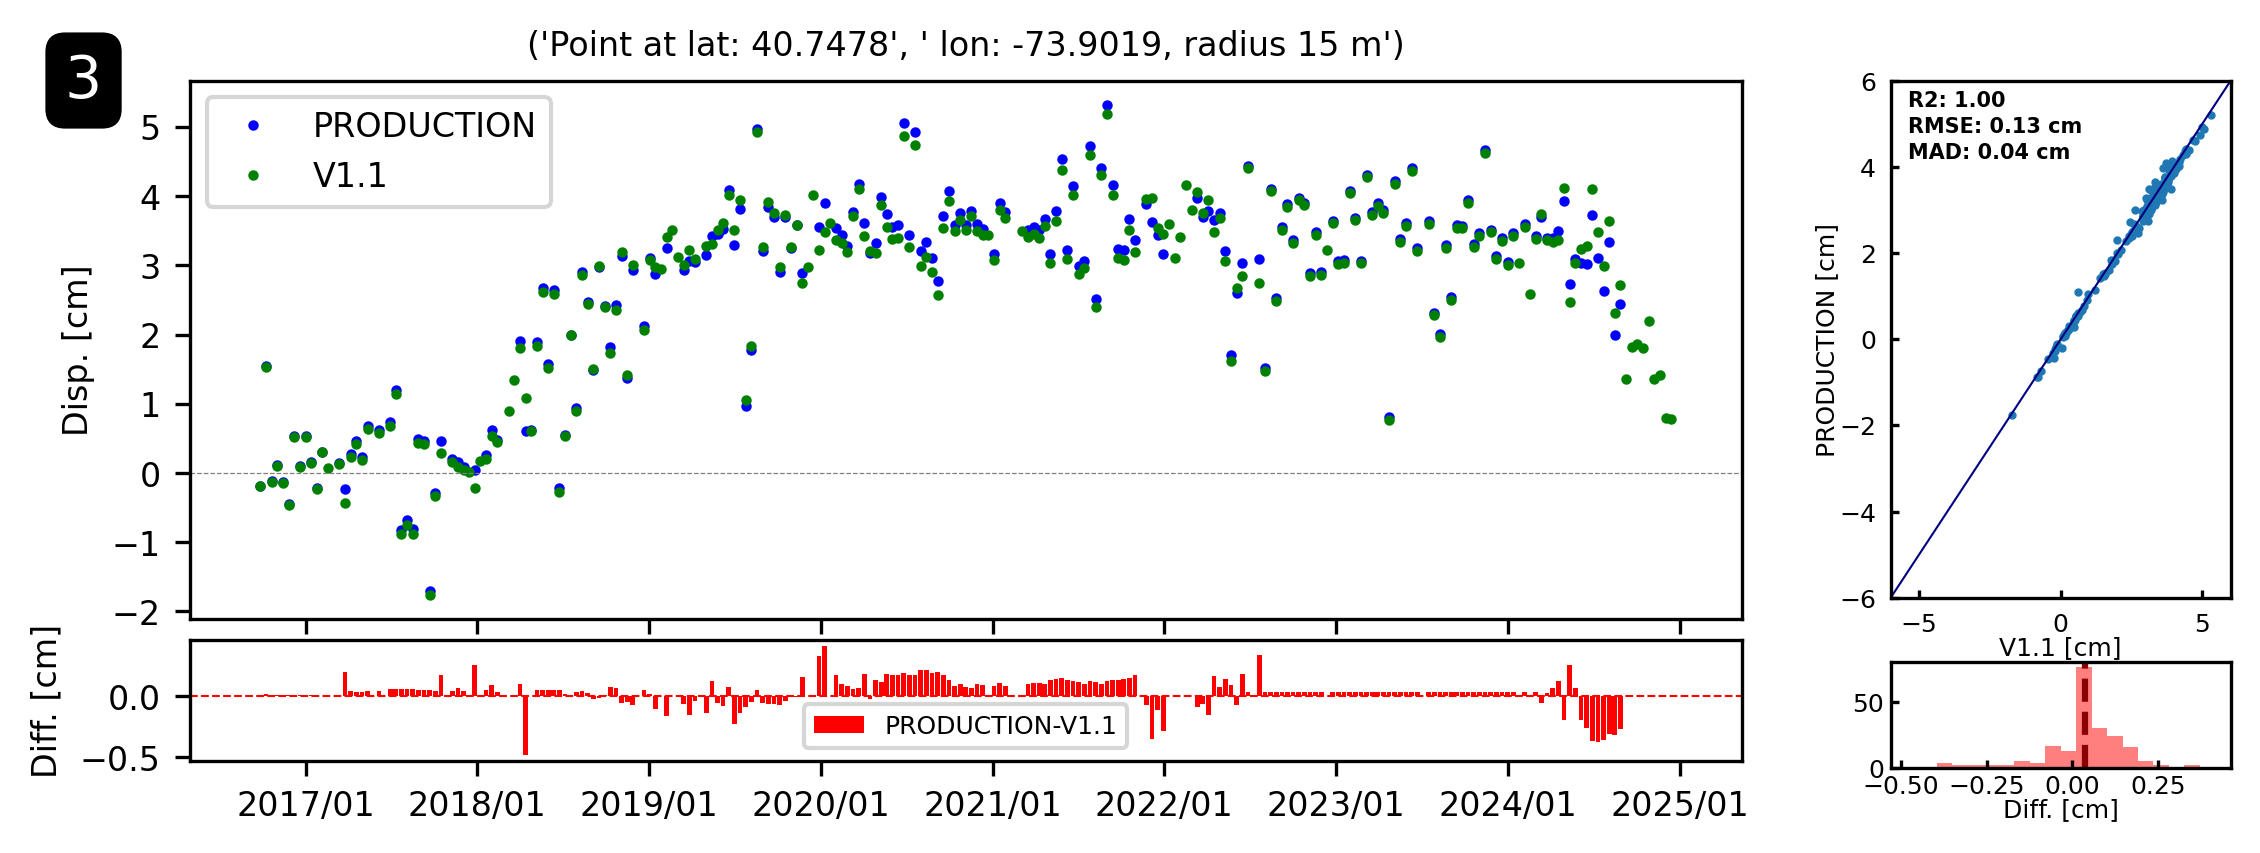

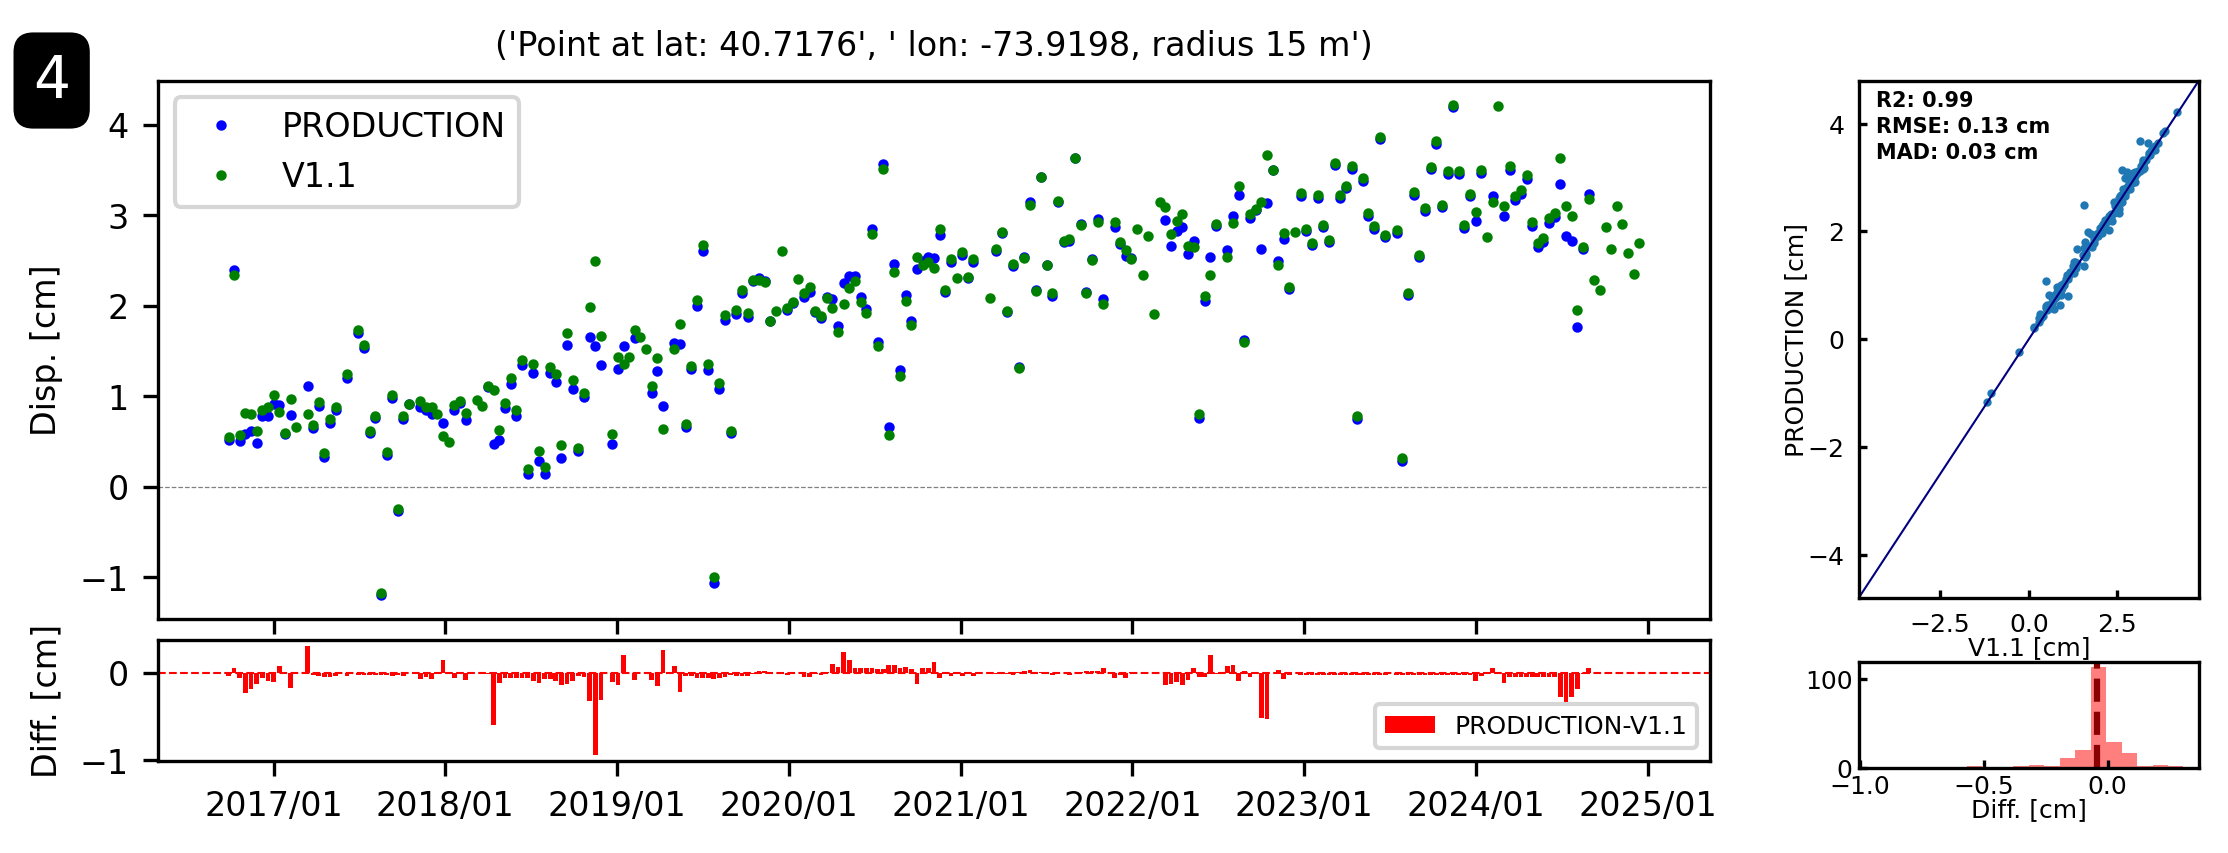

In [137]:
%%time
# Plot all selected points
radius = 15 #m select radius close to size of one cell
for ix, (point_lonlat, point_utm) in enumerate(zip(ts_points, ts_point_utm)):
    # Get production timeseries 
    ts1 = get_timeseries(stack_prod, 
                   x=point_utm[0], y=point_utm[1],
                   ref_yx=(ref_y_utm, ref_x_utm), radius=radius)
    # Get v11 timeseries 
    ts2 = get_timeseries(stack_v11, 
                   x=point_utm[0], y=point_utm[1],
                   ref_yx=(ref_y_utm, ref_x_utm), radius=radius)
    # Plot timeseries
    fig_ts, ax_ts = plot_timeseries(ts1, ts2, labels=['PRODUCTION', 'v1.1'])
    ax_ts['ts'].set_title((f'Point at lat: {point_lonlat[1]:.4f}',
                     f' lon: {point_lonlat[0]:.4f}, radius {radius:.3g} m'),
                fontsize=8)
    fig_ts.text(-0.02, 0.98, str(ix+1), fontsize=14, color="white",
         ha="center", va="center",
         bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="black"))

## "Noise" around Reference point
with assumption that area is non deforming around reference 

In [183]:
def get_reference_mean_var(ds:xr.Dataset, ref_yx:tuple, radius:float=10):
    # Get the displacement timeseries at the point
    selection = dict(y=slice(ref_yx[0] + radius, ref_yx[0] - radius),
                     x=slice(ref_yx[1] - radius, ref_yx[1] + radius))

    ts = ds.sel(selection).displacement
    mask = ds.sel(selection).recommended_mask 

    # Get the average of values within the radius
    avg_ts = ts.where(mask==1).mean(dim=['x','y'])

    # Get the reference data
    reference_ts = ds.sel(y=ref_yx[0], x=ref_yx[1], method='nearest').displacement

    # Rereference the timeseries
    avg_ts -= reference_ts

    return avg_ts.compute()

CPU times: user 21.7 s, sys: 5.25 s, total: 27 s
Wall time: 39.9 s


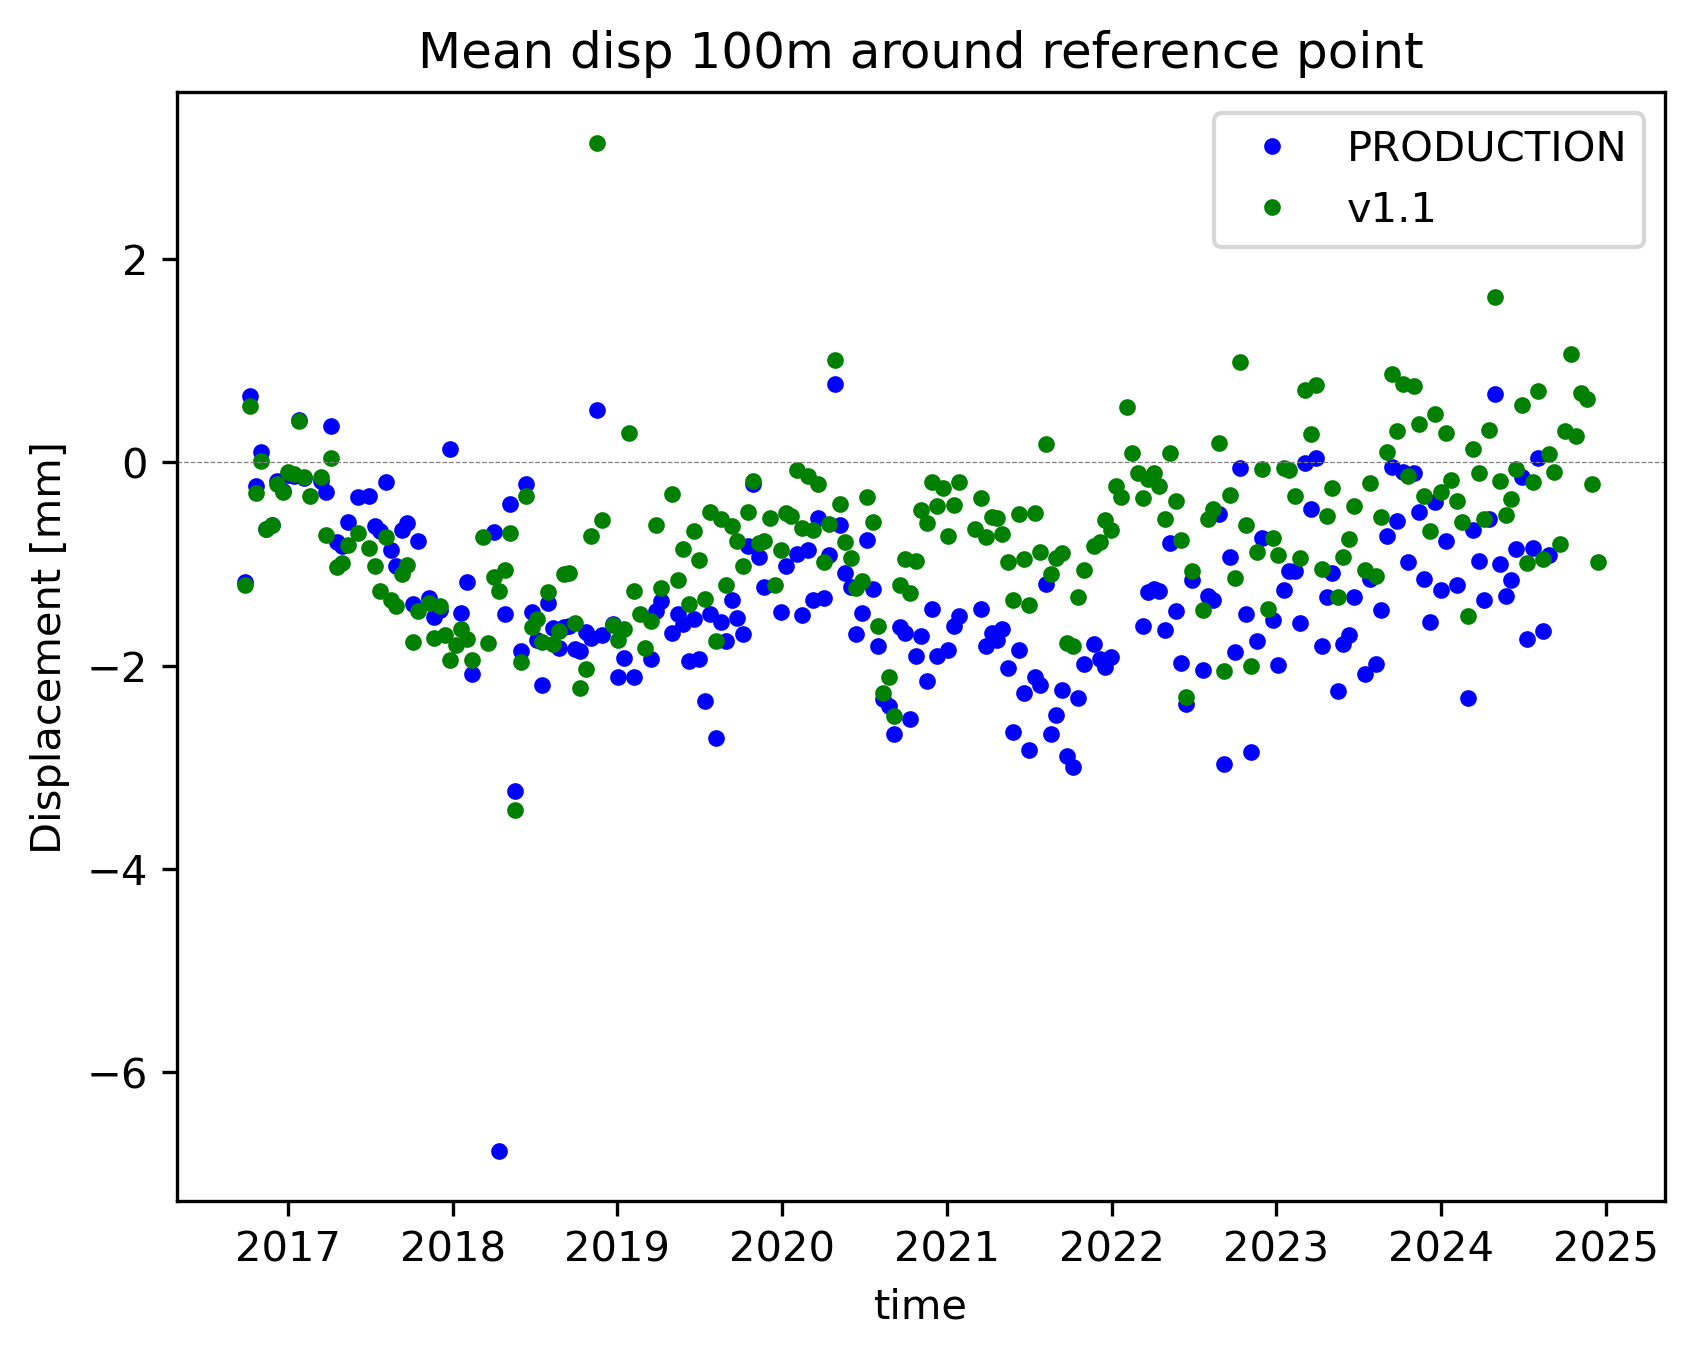

In [189]:
%%time
r = 100 ## 100m radius
ref_yx=(ref_y_utm, ref_x_utm)
prod_r = get_reference_mean_var(stack_prod, ref_yx, radius=r)
v11_r = get_reference_mean_var(stack_v11, ref_yx, radius=r)

fig, ax = plt.subplots(1,1, dpi=300)
(prod_r*1e3).plot(ax=ax, marker='.', color='blue', linestyle='', lw=None, label='PRODUCTION')
(v11_r*1e3).plot(ax=ax, marker='.', color='green', linestyle='', lw=None, label='v1.1')
ax.legend()
ax.set_title(f'Mean disp {r}m around reference point')
ax.set_ylabel('Displacement [mm]')
ax.axhline(0, color='gray', lw=0.3, linestyle='--')